In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
import os

In [15]:
# Load the matches
with open('../data/matches.json', 'r') as f:
    matches = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(matches)

# Extract art style from image path
df['art_style'] = df['image_path'].apply(lambda x: x.split('/')[0])

# Load MIDI features
midi_features = pd.read_csv('../data/maestro/midi_features.csv')

# Merge with MIDI features
df_full = df.merge(
    midi_features,
    left_on='midi_path',
    right_on='path',
    how='left'
)

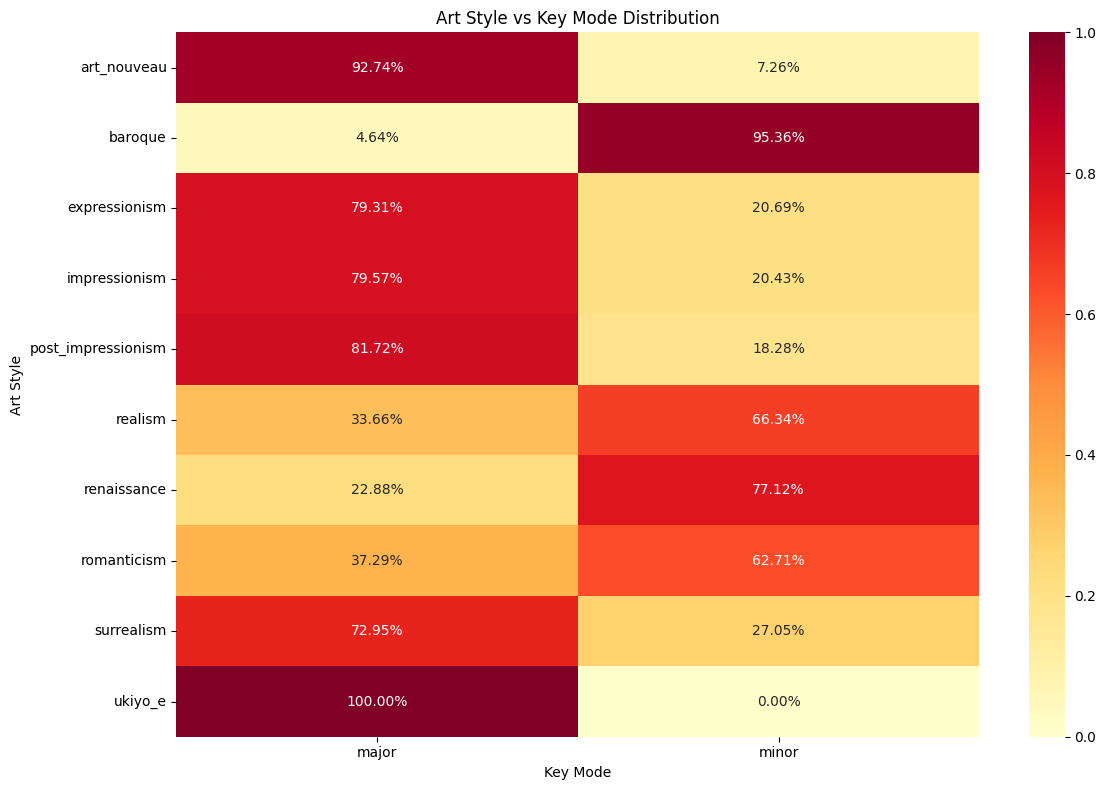

In [16]:
# Analyze style-key relationships
style_key_matrix = pd.crosstab(df_full['art_style'], df_full['key_mode'])
style_key_pct = style_key_matrix.div(style_key_matrix.sum(axis=1), axis=0)

# Create heatmap of style-key relationships
plt.figure(figsize=(12, 8))
sns.heatmap(style_key_pct, annot=True, fmt='.2%', cmap='YlOrRd')
plt.title('Art Style vs Key Mode Distribution')
plt.ylabel('Art Style')
plt.xlabel('Key Mode')
plt.tight_layout()
plt.show()


In [17]:
# Analyze average compatibility score by style and mode
avg_scores = df_full.groupby(['art_style', 'key_mode'])['compatibility_score'].agg([
    'mean', 'count', 'std'
]).round(4)
print("\nAverage Compatibility Scores by Style and Mode:")
print(avg_scores.sort_values('mean', ascending=False))


Average Compatibility Scores by Style and Mode:
                               mean  count     std
art_style          key_mode                       
baroque            major     0.8291     14  0.0084
realism            major     0.8286     34  0.0107
post_impressionism major     0.8283     76  0.0105
renaissance        major     0.8283     27  0.0107
art_nouveau        major     0.8282    166  0.0107
ukiyo_e            major     0.8277     34  0.0087
surrealism         major     0.8271     89  0.0079
expressionism      major     0.8266     92  0.0105
impressionism      major     0.8264     74  0.0089
romanticism        major     0.8245     44  0.0102
renaissance        minor     0.8211     91  0.0107
expressionism      minor     0.8210     24  0.0070
baroque            minor     0.8207    288  0.0094
impressionism      minor     0.8204     19  0.0067
realism            minor     0.8204     67  0.0101
romanticism        minor     0.8198     74  0.0118
surrealism         minor     0.81

In [18]:
# Find top matches overall
print("\nTop 10 Highest-Scoring Matches:")
top_matches = df_full.nlargest(10, 'compatibility_score')
for _, match in top_matches.iterrows():
    print(f"\nScore: {match['compatibility_score']:.4f}")
    print(f"Art Style: {match['art_style']}")
    print(f"Image: {match['image_path']}")
    print(f"Music: {os.path.basename(match['midi_path'])}")
    print(f"Key: {match['key_tonic']} {match['key_mode']}")
    print(f"Average Pitch: {match['avg_pitch']:.2f}")


Top 10 Highest-Scoring Matches:

Score: 0.8643
Art Style: post_impressionism
Image: post_impressionism/pablo-picasso_spouses-sisley-after-the-the-betrothed-by-auguste-renoir-1919.jpg
Music: ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--4.midi
Key: A- major
Average Pitch: 74.14

Score: 0.8630
Art Style: expressionism
Image: expressionism/rafael-zabaleta_maternity.jpg
Music: MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--5.midi
Key: E major
Average Pitch: 72.75

Score: 0.8614
Art Style: art_nouveau
Image: art_nouveau/dorothy-lathrop_a-little-boy-lost-1920-1.jpg
Music: MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_06_WAV.midi
Key: C# major
Average Pitch: 71.89

Score: 0.8599
Art Style: art_nouveau
Image: art_nouveau/sergey-solomko_costume-designs-1.jpg
Music: MIDI-Unprocessed_15_R1_2006_01-05_ORIG_MID--AUDIO_15_R1_2006_04_Track04_wav.midi
Key: C# major
Average Pitch: 71.77

Score: 0.8595
Art Style: art_nouveau
Image: art_nouveau/nichola

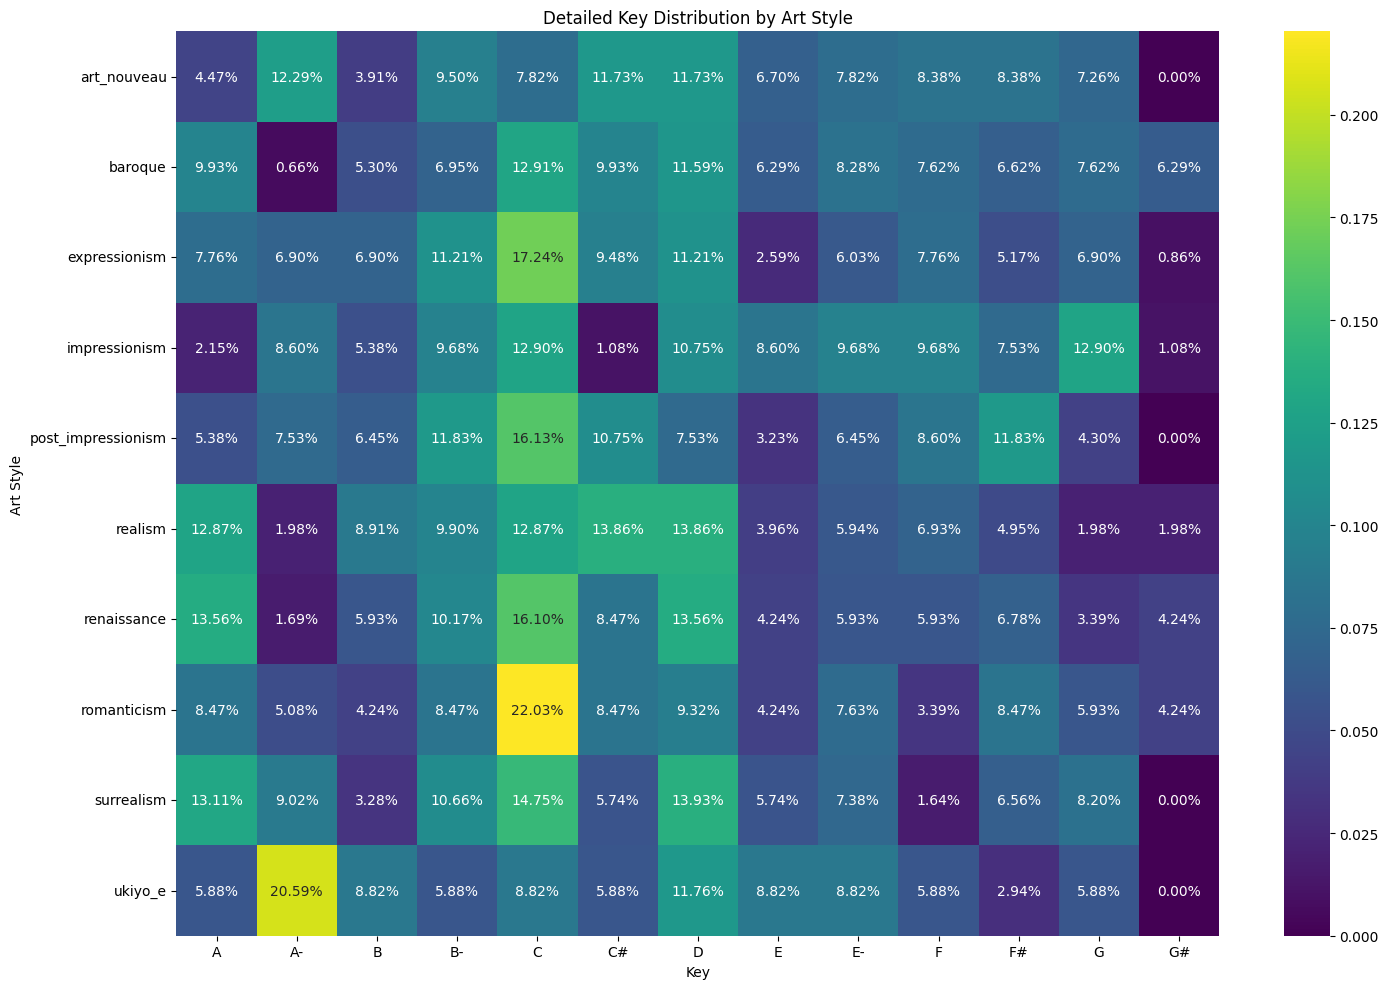

In [21]:
# Analyze key distribution within each style
style_key_detail = pd.crosstab(df_full['art_style'], df_full['key_tonic'])
style_key_pct_detail = style_key_detail.div(style_key_detail.sum(axis=1), axis=0)

# Plot key distribution for each style
plt.figure(figsize=(15, 10))
sns.heatmap(style_key_pct_detail, annot=True, fmt='.2%', cmap='viridis')
plt.title('Detailed Key Distribution by Art Style')
plt.ylabel('Art Style')
plt.xlabel('Key')
plt.tight_layout()
plt.show()


In [22]:
# Calculate style summary statistics
style_summary = df_full.groupby('art_style').agg({
    'compatibility_score': ['mean', 'std', 'min', 'max', 'count'],
    'key_mode': lambda x: x.value_counts().index[0],  # most common mode
    'key_tonic': lambda x: x.value_counts().index[0]  # most common key
}).round(4)

print("\nArt Style Summary Statistics:")
print(style_summary)


Art Style Summary Statistics:
                   compatibility_score                               key_mode  \
                                  mean     std     min     max count <lambda>   
art_style                                                                       
art_nouveau                     0.8276  0.0108  0.7945  0.8614   179    major   
baroque                         0.8211  0.0095  0.7896  0.8512   302    minor   
expressionism                   0.8254  0.0101  0.8006  0.8630   116    major   
impressionism                   0.8251  0.0088  0.8058  0.8554    93    major   
post_impressionism              0.8265  0.0114  0.7959  0.8643    93    major   
realism                         0.8232  0.0110  0.7855  0.8579   101    minor   
renaissance                     0.8227  0.0111  0.7857  0.8523   118    minor   
romanticism                     0.8216  0.0114  0.7859  0.8561   118    minor   
surrealism                      0.8250  0.0087  0.8014  0.8479   122    major 

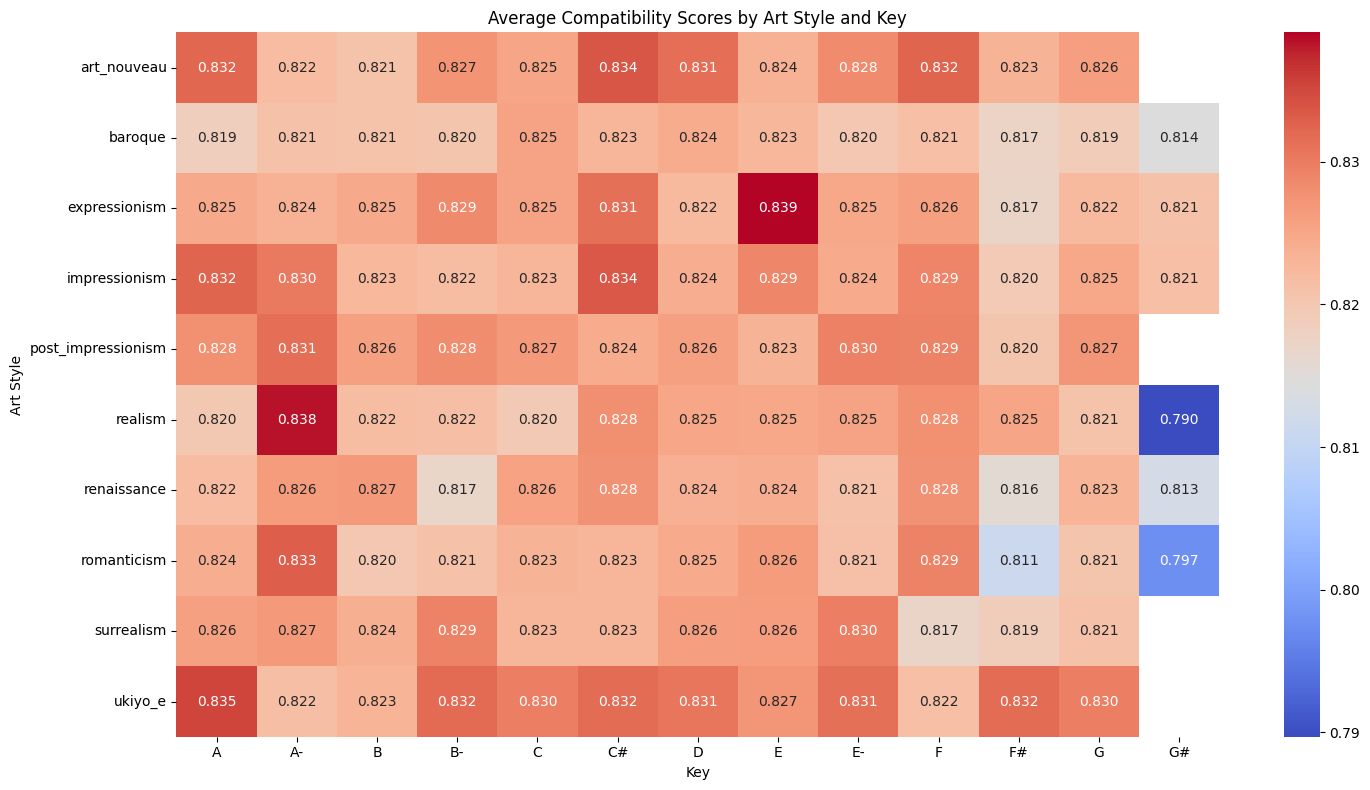

In [23]:
# Analyze if certain keys work better with certain styles
key_style_scores = df_full.groupby(['art_style', 'key_tonic'])['compatibility_score'].mean().unstack()

plt.figure(figsize=(15, 8))
sns.heatmap(key_style_scores, annot=True, fmt='.3f', cmap='coolwarm')
plt.title('Average Compatibility Scores by Art Style and Key')
plt.ylabel('Art Style')
plt.xlabel('Key')
plt.tight_layout()
plt.show()